## Importing the necessary libraries

In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, SimpleRNN, SimpleRNNCell, Embedding, Reshape
from tensorflow.keras.regularizers import L1

C:\Users\nawaf\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Importing the NAB Dataset

In [255]:
# df = pd.read_csv('./NAB/data/artificialNoAnomaly/art_daily_no_noise.csv')
df = pd.read_csv('./NAB/data/artificialWithAnomaly/art_daily_nojump.csv')

In [256]:
input_shape = (df.shape[0], )
input_shape

(4032,)

In [257]:
df.head()

,timestamp,value
0,2014-04-01 00:00:00,21.598011
1,2014-04-01 00:05:00,19.321392
2,2014-04-01 00:10:00,21.399938
3,2014-04-01 00:15:00,18.373916
4,2014-04-01 00:20:00,18.167499


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


In [259]:
df['timestamp'].min(), df['timestamp'].max()

('2014-04-01 00:00:00', '2014-04-14 23:55:00')

## Visualizing the Data

In [260]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['value']))
fig.show()

## Data Preprocessing

In [261]:
# Train and Test Split
train = df.loc[df['timestamp'] < '2014-04-10']
test = df.loc[df['timestamp'] >= '2014-04-10']

train.shape, test.shape

((2592, 2), (1440, 2))

In [262]:
# Scaling
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['value']).reshape(-1,1))

train['value'] = scaler.transform(np.array(train['value']).reshape(-1,1))
test['value'] = scaler.transform(np.array(test['value']).reshape(-1,1))

# df['value'] = scaler.transform(np.array(df['value']).reshape(-1,1))

C:\Users\nawaf\AppData\Local\Temp\ipykernel_3456\2578323148.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nawaf\AppData\Local\Temp\ipykernel_3456\2578323148.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [295]:
test['value']

2592   -0.797427
2593   -0.808996
2594   -0.795151
2595   -0.806099
2596   -0.800390
          ...   
4027   -0.858541
4028   -0.822759
4029   -0.750067
4030   -0.734837
4031   -0.837539
Name: value, Length: 1440, dtype: float64

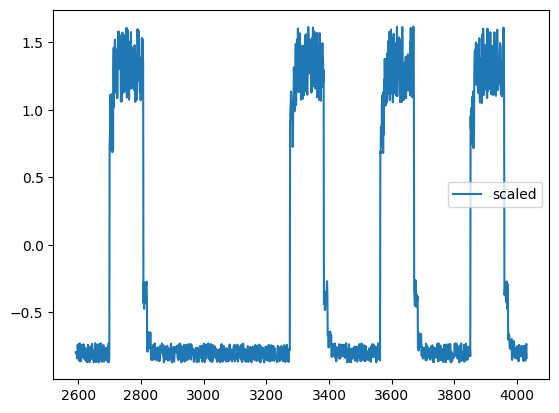

In [264]:
# Visualize scaled data
plt.plot(test['value'], label = 'scaled')
plt.legend()
plt.show()

In [265]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (2562, 30, 1)
Testing input shape:  (1410, 30, 1)


In [266]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Building the Model

In [226]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [444]:
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.3))
model.add(RepeatVector(X_train.shape[1]))
model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(rate=0.3))
# model.add(RepeatVector(X_train.shape[1]))
model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(rate=0.3))
# model.add(LSTM(128, activation='tanh', return_sequences=True))
# model.add(Dropout(rate=0.3))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss="mse")
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_17 (SimpleRNN)   (None, 128)               16640     
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_20 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 30, 128)           32896     
                                                                 
 dropout_36 (Dropout)        (None, 30, 128)           0         
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 30, 128)           32896     
                                                     

In [446]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.3))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'sigmoid', return_sequences=True))
model.add(Dropout(rate=0.3))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss="mse")
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_21 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 lstm_25 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_39 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 1)            129       
 stributed)                                          

In [447]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
57/57 [==============================] - 7s 67ms/step - loss: 1.0749 - val_loss: 0.3507
Epoch 2/100
57/57 [==============================] - 4s 63ms/step - loss: 0.3063 - val_loss: 0.2868
Epoch 3/100
57/57 [==============================] - 4s 62ms/step - loss: 0.2936 - val_loss: 0.2796
Epoch 4/100
57/57 [==============================] - 4s 64ms/step - loss: 0.2615 - val_loss: 0.2761
Epoch 5/100
57/57 [==============================] - 4s 63ms/step - loss: 0.2551 - val_loss: 0.2779
Epoch 6/100
57/57 [==============================] - 4s 63ms/step - loss: 0.2538 - val_loss: 0.2747
Epoch 7/100
57/57 [==============================] - 4s 63ms/step - loss: 0.2432 - val_loss: 0.2711
Epoch 8/100
57/57 [==============================] - 4s 65ms/step - loss: 0.2429 - val_loss: 0.2782
Epoch 9/100
57/57 [==============================] - 4s 65ms/step - loss: 0.2429 - val_loss: 0.2657
Epoch 10/100
57/57 [==============================] - 4s 63ms/step - loss: 0.2332 - val_loss: 0.2636

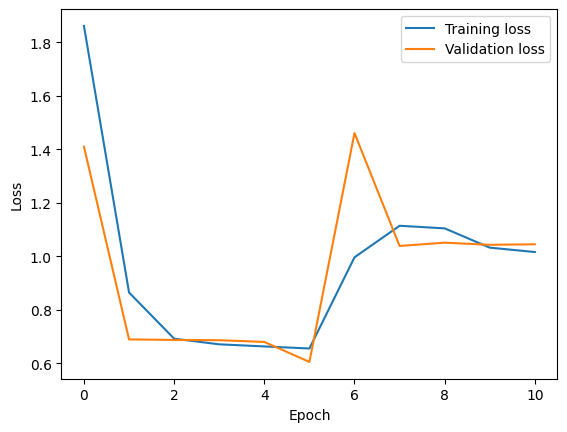

In [435]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

81/81 [==============================] - 1s 9ms/step
Reconstruction error threshold: 1.3826648559839885


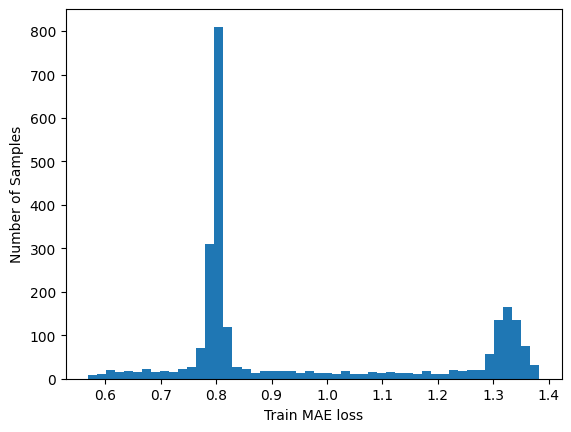

In [436]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

## Detecting Anomalies

45/45 [==============================] - 1s 18ms/step


Text(0, 0.5, 'Number of samples')

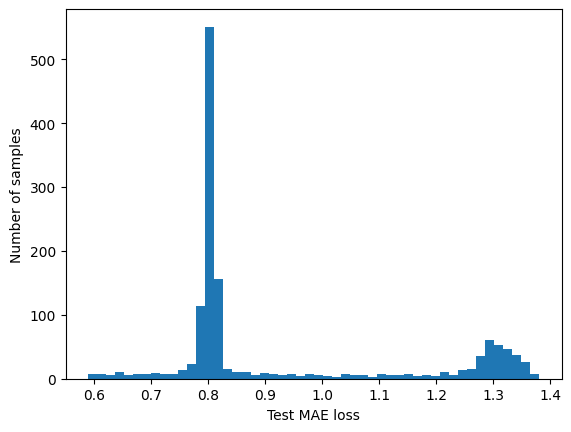

In [437]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [438]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold-0.1
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']
anomaly_df

,timestamp,value,loss,threshold,anomaly
2622,2014-04-10 02:30:00,-0.853642,0.794572,1.282665,False
2623,2014-04-10 02:35:00,-0.809751,0.796434,1.282665,False
2624,2014-04-10 02:40:00,-0.772446,0.796465,1.282665,False
2625,2014-04-10 02:45:00,-0.814056,0.795712,1.282665,False
2626,2014-04-10 02:50:00,-0.863729,0.795972,1.282665,False
...,...,...,...,...,...
4027,2014-04-14 23:35:00,-0.858541,0.795105,1.282665,False
4028,2014-04-14 23:40:00,-0.822759,0.797729,1.282665,False
4029,2014-04-14 23:45:00,-0.750067,0.798505,1.282665,False
4030,2014-04-14 23:50:00,-0.734837,0.795392,1.282665,False


In [439]:
anomaly_df.head()

,timestamp,value,loss,threshold,anomaly
2622,2014-04-10 02:30:00,-0.853642,0.794572,1.282665,False
2623,2014-04-10 02:35:00,-0.809751,0.796434,1.282665,False
2624,2014-04-10 02:40:00,-0.772446,0.796465,1.282665,False
2625,2014-04-10 02:45:00,-0.814056,0.795712,1.282665,False
2626,2014-04-10 02:50:00,-0.863729,0.795972,1.282665,False


In [440]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [441]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,timestamp,value,loss,threshold,anomaly
2736,2014-04-10 12:00:00,1.063033,1.286756,1.282665,True
2737,2014-04-10 12:05:00,1.124448,1.293601,1.282665,True
2738,2014-04-10 12:10:00,1.125575,1.295718,1.282665,True
2739,2014-04-10 12:15:00,1.062539,1.302700,1.282665,True
2740,2014-04-10 12:20:00,1.115592,1.315246,1.282665,True


In [442]:
anomaly_df

,timestamp,value,loss,threshold,anomaly
2622,2014-04-10 02:30:00,-0.853642,0.794572,1.282665,False
2623,2014-04-10 02:35:00,-0.809751,0.796434,1.282665,False
2624,2014-04-10 02:40:00,-0.772446,0.796465,1.282665,False
2625,2014-04-10 02:45:00,-0.814056,0.795712,1.282665,False
2626,2014-04-10 02:50:00,-0.863729,0.795972,1.282665,False
...,...,...,...,...,...
4027,2014-04-14 23:35:00,-0.858541,0.795105,1.282665,False
4028,2014-04-14 23:40:00,-0.822759,0.797729,1.282665,False
4029,2014-04-14 23:45:00,-0.750067,0.798505,1.282665,False
4030,2014-04-14 23:50:00,-0.734837,0.795392,1.282665,False


In [443]:
value_df = pd.DataFrame(anomaly_df['value'])
value_anomaly = pd.DataFrame(anomalies['value'])

fig = go.Figure()
# fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=scaler.inverse_transform(np.array(anomaly_df['value']).reshape(-1,1)), name='Value'))
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['value'], name='Value'))
# fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=scaler.inverse_transform(np.array(anomalies['value']).reshape(-1,1)), mode='markers', name='Anomaly'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=anomalies['value'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()